In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier
from sklearn.svm import SVC,NuSVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
testset = pd.read_csv("test.csv")
trainset = pd.read_csv("train.csv")

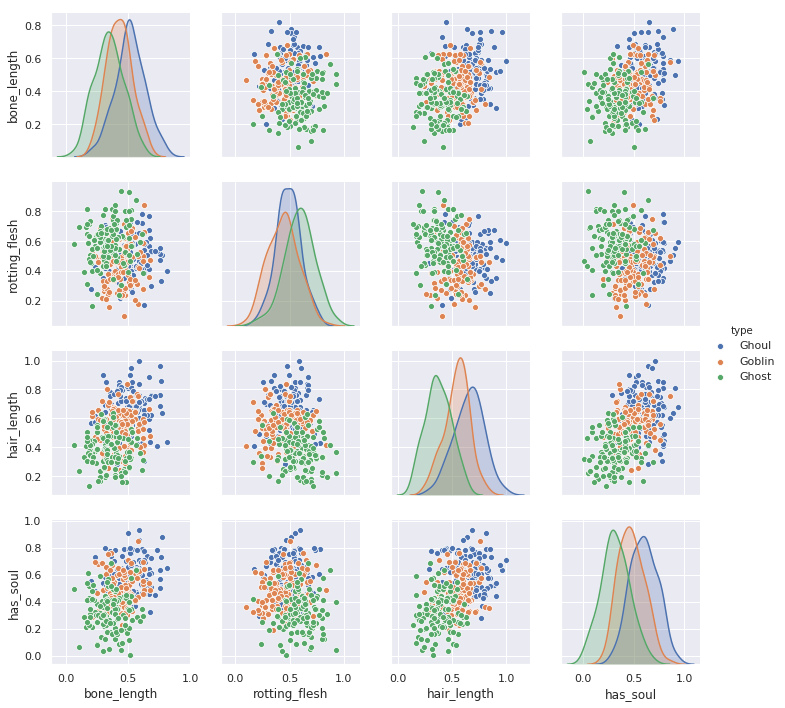

In [6]:
sns.set()
sns.pairplot(trainset[["bone_length","rotting_flesh","hair_length","has_soul","color","type"]],hue="type")


In [8]:
trainset['hair_soul'] = trainset.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)
trainset['hair_bone'] = trainset.apply(lambda row: row['hair_length']*row['bone_length'],axis=1)
trainset['bone_soul'] = trainset.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
trainset['hair_soul_bone'] = trainset.apply(lambda row: row['hair_length']*row['has_soul']*row['bone_length'],axis=1)

testset['hair_soul'] = testset.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)
testset['hair_bone'] = testset.apply(lambda row: row['hair_length']*row['bone_length'],axis=1)
testset['bone_soul'] = testset.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
testset['hair_soul_bone'] = testset.apply(lambda row: row['hair_length']*row['has_soul']*row['bone_length'],axis=1)

In [9]:
#x = pd.concat([trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]], pd.get_dummies(trainset["color"])], axis=1)
x = trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]]
x_original = trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
x_hair_soul = trainset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul"]]
y = trainset[["type"]]
#x_test = pd.concat([testset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]], pd.get_dummies(testset["color"])], axis=1)
x_test = testset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul", "hair_bone", "bone_soul", "hair_soul_bone"]]
x_test_original = testset[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
x_test_hair_soul = testset[["bone_length", "rotting_flesh", "hair_length", "has_soul", "hair_soul"]]

In [10]:
clfs = {}

In [12]:
clfs['tr'] = {'clf': DecisionTreeClassifier(), 'name':'DecisionTree'}
clfs['nusvc'] = {'clf': NuSVC(), 'name': 'NuSVC'}
clfs['linearsvc'] = {'clf': LinearSVC(), 'name': 'LinearSVC'}
clfs['SGD'] = {'clf': SGDClassifier(), 'name': 'SGDClassifier'}
clfs['GPC'] = {'clf': GaussianProcessClassifier(), 'name': 'GaussianProcess'}
clfs['nb'] = {'clf': GaussianNB(), 'name':'GaussianNaiveBayes'}
clfs['bag'] = {'clf': BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5), 'name': "BaggingClassifier"}
clfs['gbc'] = {'clf': GradientBoostingClassifier(), 'name': 'GradientBoostingClassifier'}
#clfs['mlp'] = {'clf': neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=1e-5, solver='lbfgs', max_iter=500), 'name': 'MultilayerPerceptron'}

In [13]:
parameters = {'solver': ['lbfgs'], 'max_iter': [1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12)}
clfs['mlpgrid'] = {'clf': GridSearchCV(MLPClassifier(), parameters,cv=3), 'name': 'MLP with GridSearch'}

parameters = {'kernel':['linear', 'sigmoid', 'poly', 'rbf'], 'gamma':np.linspace(0.0,2.0,num=21),'C': np.linspace(0.5,1.5,num=11)}
clfs['svcgrid'] = {'clf': GridSearchCV(SVC(), parameters,cv=3), 'name': 'SVC with GridSearch'}

parameters = {'n_estimators':np.arange(64, 1024, step=64)}
clfs['rfgrid'] = {'clf': GridSearchCV(RandomForestClassifier(), parameters,cv=3), 'name': 'Random Forest with GridSearch'}

parameters = {'n_neighbors':np.arange(3, 12)}
clfs['knngrid'] = {'clf': GridSearchCV(KNeighborsClassifier(), parameters,cv=3), 'name': 'KNN with GridSearch'}

parameters = {'n_estimators':np.arange(3, 12)}
clfs['adagrid'] = {'clf': GridSearchCV(AdaBoostClassifier(), parameters,cv=3), 'name': 'AdaBoost with GridSearch'}

parameters = {'C':[1],'tol':[0.0001],'solver': ['newton-cg'], 'multi_class': ['multinomial']}
clfs['lrgrid'] = {'clf': GridSearchCV(LogisticRegression(), parameters,cv=3), 'name': 'LogisticRegression with GridSearch'}


In [14]:
for clf in clfs:
    clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], x_original, y.values.ravel(), cv=5)
    print(clfs[clf]['name'] + ": %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))
    #clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], x, y.values.ravel(), cv=5)
    #print(clfs[clf]['name'] + " (with all artificial features): %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))
    clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], x_hair_soul, y.values.ravel(), cv=5)
    print(clfs[clf]['name'] + " (with hair_soul feature): %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))
    

DecisionTree: 0.6577 (+/- 0.0679)
DecisionTree (with hair_soul feature): 0.6445 (+/- 0.0772)
NuSVC: 0.7091 (+/- 0.1135)
NuSVC (with hair_soul feature): 0.7277 (+/- 0.0895)
LinearSVC: 0.7249 (+/- 0.1057)
LinearSVC (with hair_soul feature): 0.7303 (+/- 0.1095)
SGDClassifier: 0.6198 (+/- 0.1254)


/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/

SGDClassifier (with hair_soul feature): 0.6603 (+/- 0.0650)
GaussianProcess: 0.7330 (+/- 0.0799)
GaussianProcess (with hair_soul feature): 0.7276 (+/- 0.0626)
GaussianNaiveBayes: 0.7413 (+/- 0.0662)
GaussianNaiveBayes (with hair_soul feature): 0.7250 (+/- 0.0676)
BaggingClassifier: 0.6977 (+/- 0.0933)
BaggingClassifier (with hair_soul feature): 0.7384 (+/- 0.0717)
GradientBoostingClassifier: 0.7195 (+/- 0.0701)
GradientBoostingClassifier (with hair_soul feature): 0.7385 (+/- 0.0613)


/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_s

MLP with GridSearch: 0.7137 (+/- 0.1329)


/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_s

MLP with GridSearch (with hair_soul feature): 0.7224 (+/- 0.1089)


/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_s

SVC with GridSearch: 0.7493 (+/- 0.0949)


/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_s

SVC with GridSearch (with hair_soul feature): 0.7466 (+/- 0.0626)


/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/birnesh/anaconda3/lib/python3.7/site-packages/sklearn/model_s

Random Forest with GridSearch: 0.7249 (+/- 0.0594)


KeyboardInterrupt: 

In [ ]:
clfs['vote_hair_soul'] = {'clf': VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('gbc', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifierHairSoul'}

# classifiers using the original features
clfs['vote'] = {'clf': VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('nb', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifier'}
    

In [1]:
#for clf in clfs:
#    clfs[clf]['clf'].fit(x, y.values.ravel())
    
clfs['vote_hair_soul']['clf'] = clfs['vote_hair_soul']['clf'].fit(x_hair_soul, y.values.ravel())
clfs['vote']['clf'] = clfs['vote']['clf'].fit(x_original, y.values.ravel())

NameError: name 'clfs' is not defined

In [13]:
import numpy as np
print(np.ones((3,2)))

[[1. 1.]
 [1. 1.]
 [1. 1.]]
